# Opens fits files and displays info, works with csvs to produce location plots etc.

In [1]:
# Call the relevant python packages

%matplotlib notebook

import numpy as np
import pandas as pd
import glob, os
import nway

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from astropy import units as u
from astropy.io import ascii, fits
from astropy.table import join, hstack, Table, Column, vstack
from astropy.coordinates import Angle, Latitude, Longitude, SkyCoord

# Set colour palette & plot layouts
import seaborn as sns     #; sns.set()
sns.set_context("paper")   # "paper", "notebook", "talk", "poster"

# Fits Files

In [6]:
# Open a fits file and display info
filein = 'all36_combined.fits'
fits_im = fits.open(filein)
fits_im.info()

# Print data
data = fits_im[1].data
print(len(data))
print(data[13290:13296])

Filename: all36_combined.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1  NWAYMATCH     1 BinTableHDU     63   13296R x 27C   [21A, D, D, D, D, 21A, D, D, D, D, 21A, D, D, D, D, E, E, E, E, I, E, E, E, E, E, E, I]   
13296
[('12080', 10.67148311, 40.87067169, 14.62050491, 0.1064, '-99', -99., -99., -99., -99., '-99', -99., -99., -99., -99., nan, nan, nan, 0., 1, 0., 0., 1., 1., 0., 0., 1)
 ('12081', 10.66507476, 40.88828476, 17.74850491, 0.1205, '-99', -99., -99., -99., -99., '-99', -99., -99., -99., -99., nan, nan, nan, 0., 1, 0., 0., 1., 1., 0., 0., 1)
 ('12082', 10.66507088, 40.85756401, 15.99550491, 0.1095, '-99', -99., -99., -99., -99., '-99', -99., -99., -99., -99., nan, nan, nan, 0., 1, 0., 0., 1., 1., 0., 0., 1)
 ('12083', 10.67074768, 40.85738846, 15.73050491, 0.1077, '-99', -99., -99., -99., -99., '-99', -99., -99., -99., -99., nan, nan, nan, 0., 1, 0., 0., 1., 1., 0., 0., 1)
 ('12084', 10.67700219, 40.

# Convert fits to text

In [3]:
# Print fits header fields
hdr = fits_im[1].header
hdr

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  458 / length of dimension 1                          
NAXIS2  =                11428 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   63 / number of table fields                         
TTYPE1  = 'S1_ALL_ID'                                                           
TFORM1  = '7A      '                                                            
TTYPE2  = 'S1_ALL_RA'                                                           
TFORM2  = 'D       '                                                            
TTYPE3  = 'S1_ALL_DEC'      

In [7]:
text_file = open('all_combined_special1_text.txt','w')
for i in range(8,len(hdr)-1,2):
    name = str(hdr[i])+' '
    print(name)
    text_file.write(name)
    
for i in range(len(data)):
    line = '\n'+str(data[i])[1:len(str(data[i]))-1]+' '
    text_file.write(line)
    
text_file.close()

S1_ALL_ID 
S1_ALL_RA 
S1_ALL_DEC 
S1_ALL_S1_F1_MAG1_1 
S1_ALL_S1_F1_ERR1_1 
S1_ALL_S1_F3_ID 
S1_ALL_S1_F3_RA 
S1_ALL_S1_F3_DEC 
S1_ALL_S1_F3_MAG1_3 
S1_ALL_S1_F3_ERR1_3 
S1_ALL_S1_F4_ID 
S1_ALL_S1_F4_RA 
S1_ALL_S1_F4_DEC 
S1_ALL_S1_F4_MAG1_4 
S1_ALL_S1_F4_ERR1_4 
S1_ALL_Separation_S1_F3_S1_F1 
S1_ALL_Separation_S1_F4_S1_F1 
S1_ALL_Separation_S1_F4_S1_F3 
S1_ALL_Separation_max 
S1_ALL_ncat 
S1_ALL_dist_bayesfactor 
S1_ALL_dist_bayesfactor_corrected 
S1_ALL_dist_post 
S1_ALL_p_single 
S1_ALL_p_any 
S1_ALL_p_i 
S1_ALL_match_flag 
S2_ALL_ID 
S2_ALL_RA 
S2_ALL_DEC 
S2_ALL_S2_F1_MAG2_1 
S2_ALL_S2_F1_ERR2_1 
S2_ALL_S2_F3_ID 
S2_ALL_S2_F3_RA 
S2_ALL_S2_F3_DEC 
S2_ALL_S2_F3_MAG2_3 
S2_ALL_S2_F3_ERR2_3 
S2_ALL_S2_F4_ID 
S2_ALL_S2_F4_RA 
S2_ALL_S2_F4_DEC 
S2_ALL_S2_F4_MAG2_4 
S2_ALL_S2_F4_ERR2_4 
S2_ALL_Separation_S2_F3_S2_F1 
S2_ALL_Separation_S2_F4_S2_F1 
S2_ALL_Separation_S2_F4_S2_F3 
S2_ALL_Separation_max 
S2_ALL_ncat 
S2_ALL_dist_bayesfactor 
S2_ALL_dist_bayesfactor_corrected 
S2_ALL_dist_po

# Match visualisation (ignores sky curvature)

0.24520263593797173 arcsec
5.555555555555556e-05 deg


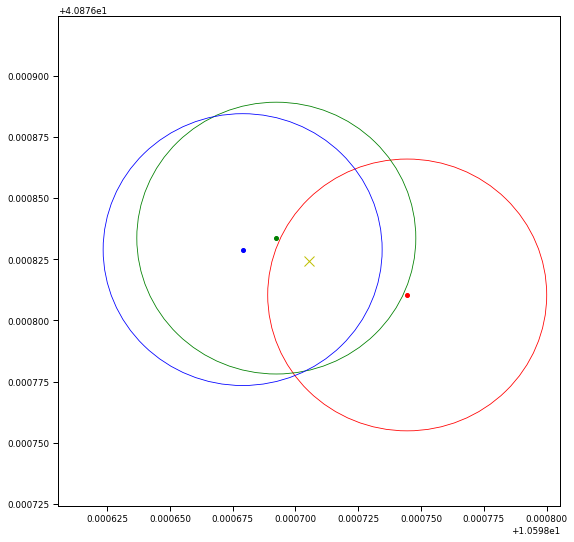

In [6]:
import math
%matplotlib inline
plt.figure(figsize=(9,9))
x1,y1 = 10.5987445,40.87681039
x2,y2 = 10.59869237,40.87683363
x3,y3 = 10.59867896,40.87682893
sep13 = math.sqrt((x3-x1)**2 + (y3-y1)**2) * u.degree
sep13 = sep13.to(u.arcsec)
print(sep13)
plt.plot(x1,y1,'ro',ms=4)
plt.plot(x2,y2,'go',ms=4)
plt.plot(x3,y3,'bo',ms=4)
stretch = 0.0001
x_mean = (x1+x2+x3)/3
y_mean = (y1+y2+y3)/3
plt.plot(x_mean,y_mean,'yx',ms=10)
plt.xlim(x_mean-stretch,x_mean+stretch)
plt.ylim(y_mean-stretch,y_mean+stretch)

ax = plt.gca()
radius = 0.2*u.arcsec
radius = radius.to(u.deg)
print(radius)
circle1 = plt.Circle((x1,y1), radius.value, color='red', fill=False) #max allowed radius
circle2 = plt.Circle((x2,y2), radius.value, color='green', fill=False) #actual separation
circle3 = plt.Circle((x3,y3), radius.value, color='blue', fill=False) #actual separation

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)

# Catalogue Operations

In [10]:
# Define function to produce 3D graph
# NB: ONLY WORKS FOR CSV FILES!!
def graph(file,filtr,epoch,var):
    # Setting up figure
    plt.rc('font', family='sans-serif')
    #plt.rc("xtick", labelsize=8)
    #plt.rc("ytick", labelsize=8)
    plt.rc("axes", labelsize=10)
    plt.rc("legend", fontsize=11)
    plt.figure(figsize=(6,6))
    #ax = plt.gca()                        # Sets up active plot region
    ax = plt.axes(projection='3d')
    
    # Make the actual plot
    data = ascii.read(file, data_start=1)
    ax.plot3D(data['RA'], data['DEC'], data[var], '.', color='black', ms=0.5, label="M32 All")
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    ax.set_zlabel(var)
    #plt.xlabel('RA', size=18)
    #plt.ylabel('DEC', size=18)
    #plt.zlabel(var, size=18)
    #plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
    #plt.title(filtr+'-'+epoch,fontsize=18)
    
    # Plot a box
    #x1,y1=[maxRA.value,minRA.value],[minDec.value,minDec.value]
    #x2,y2=[minRA.value,minRA.value],[minDec.value,maxDec.value]
    #x3,y3=[minRA.value,maxRA.value],[maxDec.value,maxDec.value]
    #x4,y4=[maxRA.value,maxRA.value],[maxDec.value,minDec.value]
    #plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='black')
    
    #plt.savefig("blah.pdf", bbox_inches='tight')
    #plt.tight_layout()
    #plt.show()
    #plt.close()

<IPython.core.display.Javascript object>


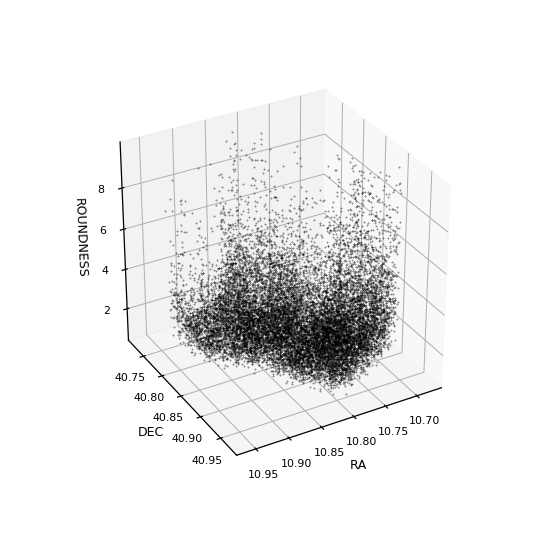

In [11]:
graph('MAG_S1_0.csv','36','background','ROUNDNESS')
#graph(csvfile,'36','background','SHARPNESS')
#graph(csvfile,'36','background','MAG1')
#graph(csvfile,'36','background','ERR1')

In [17]:
# Define function to produce location plot
def loc_plot(file,filtr,epoch):
    %matplotlib inline
    # Setting up figure
    plt.rc('font', family='sans-serif')
    plt.rc("xtick", labelsize=14)
    plt.rc("ytick", labelsize=14)
    plt.rc("axes", labelsize=14)
    plt.rc("legend", fontsize=11)
    plt.figure(figsize=(9,9))
    ax = plt.gca()                        # Sets up active plot region
    
    # Make the actual plot
    data = ascii.read(file, data_start=1)
    plt.plot(data['RA'], data['DEC'], '.', color='black', ms=0.2, label="M32 All")    
    plt.xlabel('Right Ascension (deg)', size=18)
    plt.ylabel('Declination (deg)', size=18)
    plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
    plt.title(filtr+'-'+epoch,fontsize=18)
    
    # Plot a box
    #x1,y1=[maxRA.value,minRA.value],[minDec.value,minDec.value]
    #x2,y2=[minRA.value,minRA.value],[minDec.value,maxDec.value]
    #x3,y3=[minRA.value,maxRA.value],[maxDec.value,maxDec.value]
    #x4,y4=[maxRA.value,maxRA.value],[maxDec.value,minDec.value]
    #plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='black')
    
    #plt.savefig("blah.pdf", bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    plt.close()

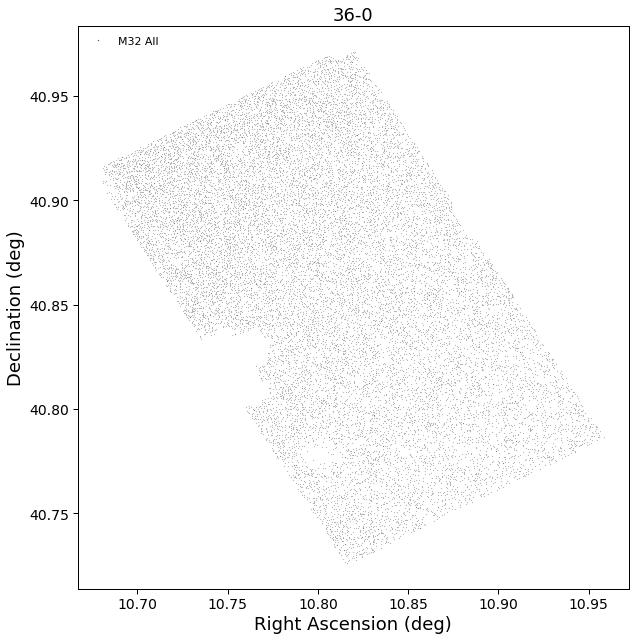

In [18]:
# Show location plot of background 36 field
loc_plot('MAG_S1_0.csv','36','0')

In [27]:
#print column names
data_36.colnames

['RA', 'DEC', 'ROUNDESS', 'SHARPNESS', 'MAG1', 'ERR1']

In [7]:
file = '36_combined_text.csv'
csv_data = ascii.read(file, header_start=0)
csv_data.colnames   # Get the column names

# Cull all those matches with a match flag !=1    
good_match_idx = np.where(csv_data['match_flag']==1)
good_data = csv_data[good_match_idx]
print(len(good_data))
# See how many remain compared to original combined [3.6]/[4.5]
match_1_pct = len(good_data)*100/len(data)
print("Amount of good match data: ",match_1_pct,"%")

# Set up columns for association number and mean coordinates
good_data['36_asn']=0
good_data['RA']=0.0
good_data['DEC']=0.0

for i in range(len(good_csv_data)):
    associations_36 = 1
    RA = good_data['S1_F1_RA'][i]
    DEC = good_data['S1_F1_DEC'][i]
    
    # -99 means no match, so ignore these
    if good_data['S1_F3_RA'][i]!=-99:
        RA = RA + good_data['S1_F3_RA'][i]
        DEC = DEC + good_data['S1_F3_DEC'][i]
        associations_36 = associations_36 + 1
    if good_data['S1_F4_RA'][i]!=-99:
        RA = RA + good_data['S1_F4_RA'][i]
        DEC = DEC + good_data['S1_F4_DEC'][i]
        associations_36 = associations_36 + 1
        
    good_data['36_asn'][i]=associations_36
    good_data['RA'][i]=RA/associations_36
    good_data['DEC'][i]=DEC/associations_36
    
asn_36_3_idx = np.where(good_data['36_asn']==3)
print(len(asn_36_3_idx[0]))
asn_36_2_idx = np.where(good_data['36_asn']==2)
print(len(asn_36_2_idx[0]))
idx_asn = np.where(good_data['36_asn']==2 | good_data['36_asn']==3)
# Cull those with no counterparts (no variability)
print("This number should be the sum of the two above:",len(idx_asn[0]))
good_data = good_data[idx_asn]
# See how many remain compared to original combined [3.6]/[4.5]
good_asn_pct = 100*len(good_data)/len(data)
print("Amount of good match data with counterpart(s): ",match_1_pct,"%")

# Rename 1st ID as ID
good_data.rename_column('S1_F1_ID', 'ID')

# Remove first and last characters of ID number ('')
for i in range(len(good_data)):
    good_data['S1_F1_ID'][i]=int(str(good_data['S1_F1_ID'][i])[1:len(str(good_data['S1_F1_ID'][i]))-1])
for i in range(len(good_data)):
    good_data['S1_F3_ID'][i]=int(str(good_data['S1_F3_ID'][i])[1:len(str(good_data['S1_F3_ID'][i]))-1])
for i in range(len(good_data)):
    good_data['S1_F4_ID'][i]=int(str(good_data['S1_F4_ID'][i])[1:len(str(good_data['S1_F4_ID'][i]))-1])

# Rename (ID, RA, Dec)1 as (ID, RA, Dec)
#good_data.rename_column('S2_F1_ID', 'ID')
#good_data.rename_column('S2_F1_RA', 'RA')
#good_data.rename_column('S2_F1_DEC', 'DEC')

# Display a small portion of the data to check formatting
good_data[0:2].show_in_notebook()

good_data.write('average_36_csv.csv', overwrite=True)
good_data.write('average_36_fits.fits', overwrite=True)

10581
Amount of good data:  79.58032490974729 %


idx,S1_F1_ID,S1_F1_RA,S1_F1_DEC,S1_F1_MAG1_1,S1_F1_ERR1_1,S1_F3_ID,S1_F3_RA,S1_F3_DEC,S1_F3_MAG1_3,S1_F3_ERR1_3,S1_F4_ID,S1_F4_RA,S1_F4_DEC,S1_F4_MAG1_4,S1_F4_ERR1_4,Separation_S1_F3_S1_F1,Separation_S1_F4_S1_F1,Separation_S1_F4_S1_F3,Separation_max,ncat,dist_bayesfactor,dist_bayesfactor_corrected,dist_post,p_single,p_any,p_i,match_flag
0,1,10.60573757,40.8624973,17.52850491,0.0556,-99,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,nan,nan,nan,0.0,1,0.0,0.0,1.0,1.0,0.0,0.0,1
1,3,10.62889238,40.81041431,17.55350491,0.0682,-99,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,nan,nan,nan,0.0,1,0.0,0.0,1.0,1.0,0.0,0.0,1


In [3]:
good_csv_file = 'all_good_36_csv.csv'
good_csv_data = ascii.read(good_csv_file, header_start=0)


<IPython.core.display.Javascript object>


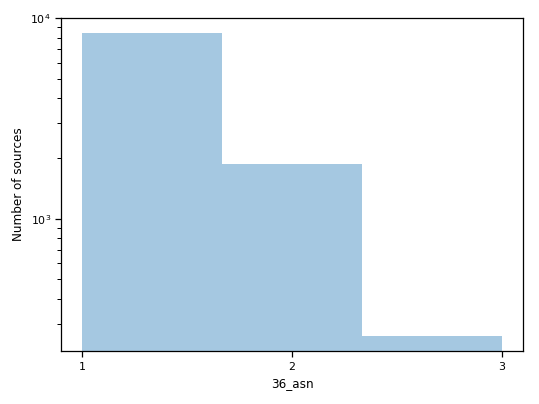

260
1870


In [15]:
ig = plt.figure(figsize=(6,4.5))
ax = sns.distplot(good_csv_data['36_asn'] ,kde=False, bins=3)
#ax = sns.countplot(pr_data[param_best_name], color='steelblue')
ax.set_yscale('log')
ax.set_ylabel('Number of sources')
plt.tight_layout()
ax.set_xticks([1,2,3])
#save_name = str('hist_'+param_best_name+'.pdf')
#plt.savefig(save_name, bbox_inches='tight')





# Can employ visualisation technique above to check mean coordinate